In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier, XGBRegressor
from skopt import BayesSearchCV
import skopt.space as space
from sklearn.pipeline import Pipeline

from ff_custom_scripts import *

In [5]:
train, test,leaderboard,holdout = load_files(nanvalues='remove')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1437) (294, 1437) (530, 1437) (1111, 1437)


# Model

In [14]:
def run_model(train, target='gpa', classifier=False):

    X_train, y_train = prepare_data(train, target)
    
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    numerical_features = cols_per_type(X_train, 'Continuous')
    categorical_features = cols_per_type(X_train, 'Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    ordinal_features = cols_per_type(X_train, 'Ordinal')
    
    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        ('passthrough', ordinal_features),
        ('passthrough', binary_features)
    )
    
    search_space = {
            'regressor__n_estimators': space.Integer(100, 1000),
            'regressor__learning_rate': space.Real(0.01, 0.05),
            'regressor__max_depth': space.Integer(2, 5),
            'regressor__subsample': space.Real(0.4, 0.8),
            'regressor__colsample_bytree': space.Real(0.4, 0.8),
        }
    
    if classifier:
        score = 'neg_brier_score'
        xgboost = XGBClassifier(n_jobs=-1, eval_metric='logloss', objective='binary:logistic')
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
           
    else:
        xgboost = XGBRegressor(n_jobs=-1, eval_metric='rmse')
        score = 'neg_mean_squared_error'
    
        
    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', xgboost)])
                            
    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=50,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=10,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    return model


In [15]:
model_eviction = run_model(alldata,target='eviction', classifier=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START regressor__colsample_bytree=0.5640415835413256, regressor__learning_rate=0.03910902972709301, regressor__max_depth=5, regressor__n_estimators=384, regressor__scale_pos_weight=12, regressor__subsample=0.5656474529942155
[CV 2/5; 1/1] START regressor__colsample_bytree=0.5640415835413256, regressor__learning_rate=0.03910902972709301, regressor__max_depth=5, regressor__n_estimators=384, regressor__scale_pos_weight=12, regressor__subsample=0.5656474529942155
[CV 3/5; 1/1] START regressor__colsample_bytree=0.5640415835413256, regressor__learning_rate=0.03910902972709301, regressor__max_depth=5, regressor__n_estimators=384, regressor__scale_pos_weight=12, regressor__subsample=0.5656474529942155
[CV 4/5; 1/1] START regressor__colsample_bytree=0.5640415835413256, regressor__learning_rate=0.03910902972709301, regressor__max_depth=5, regressor__n_estimators=384, regressor__scale_pos_weight=12, regressor__subsample=0.56

In [16]:
model_eviction.best_params_

OrderedDict([('regressor__colsample_bytree', 0.4),
             ('regressor__learning_rate', 0.05),
             ('regressor__max_depth', 2),
             ('regressor__n_estimators', 100),
             ('regressor__scale_pos_weight', 2),
             ('regressor__subsample', 0.8)])

In [37]:
score_model(model_eviction, 'eviction', test, leaderboard, holdout, classifier=True)

Test Brier: 0.0479
Test F1: 0.1250
Leaderboard Brier: 0.0547
Leaderboard F1: 0.0645
Holdout Brier: 0.0589


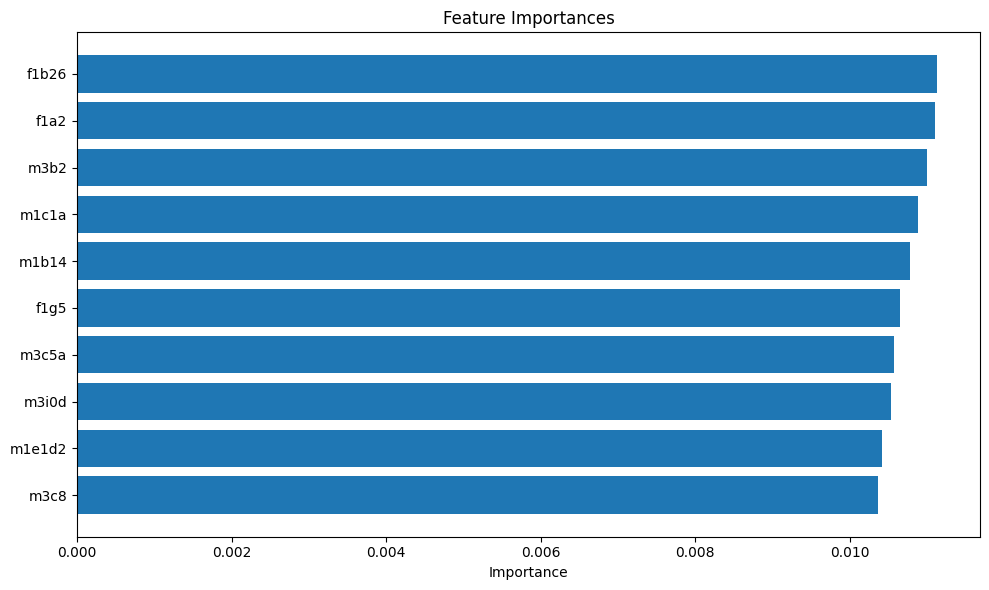

{('Found out she was preg., your rel. with bio mom got better, worse, same?',): 'f1b26',
 ('Were you present at the birth?',): 'f1a2',
 ("How is your child's health?",): 'm3b2',
 ('How imp is it for bio dad to provide regular financial support to children?',): 'm1c1a',
 ('What are the chances that you will marry bio dad in the future?',): 'm1b14',
 ('In the past year, has drinking/drugs interfered with work/relationships?',): 'f1g5',
 ('How often should father spend one or more hours a day with child?',): 'm3c5a',
 ('In past year, have you participated in: labor union or work-related group?',): 'm3i0d',
 ('People who currently live in your HH - 2nd age?',): 'm1e1d2',
 ('INT CHK: WERE MOTHER AND FATHER MARRIED AT LAST INTERVIEW?',): 'm3c8'}

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(model, feature_names, top_n=10,meta=pd.read_csv('../metadata/variables.csv', index_col=0)):
    importances = model.best_estimator_.named_steps['regressor'].feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    feature_importances = [(feature_names[i], importances[i]) for i in indices]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    feature_names = [x[0] for x in feature_importances]
    importances = [x[1] for x in feature_importances]
    vars = [meta[meta.index.isin([feat])].varlab.values for feat in feature_names]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(np.arange(len(importances)), importances, align='center')
    ax.set_yticks(np.arange(len(importances)))
    ax.set_yticklabels(feature_names)
    ax.invert_yaxis()
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importances')
    plt.tight_layout()
    plt.show()
    return (dict(zip(map(tuple, vars), feature_names)))

plot_feature_importances(model_eviction, alldata.columns)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


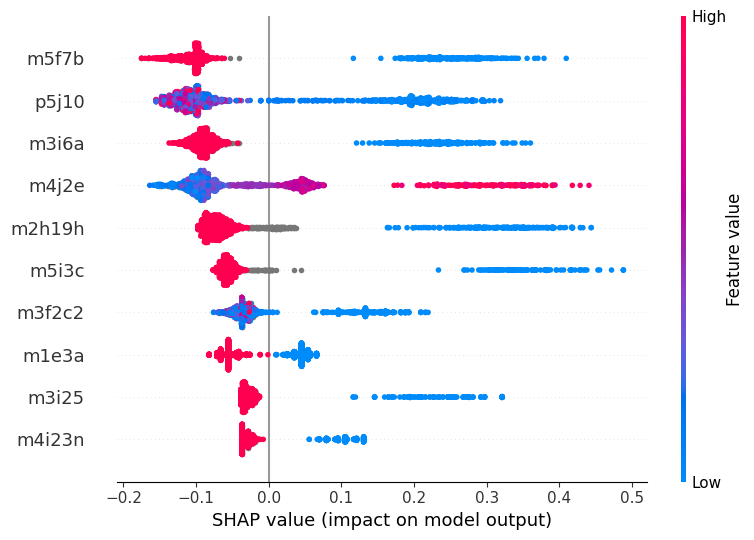

{("In past year, phone service disconnected b/c wasn't enough money?",): 'm4i23n',
 ('Have you been booked or charged with breaking the law?',): 'm3i25',
 ('During your preg, did you receive financial supp. from anyone besides bio dad?',): 'm1e3a',
 ("What is second person's age? (years)",): 'm3f2c2',
 ('I3C. You received any kind of employment counseling since last interview',): 'm5i3c',
 ('In past year, did your-Telephone service get disconnected for nonpayment?',): 'm2h19h',
 ('How much do you weigh?',): 'm4j2e',
 ('In past year, was telephone service ever disconnected?',): 'm3i6a',
 ('J10. Amount of money spent eating out in last month',): 'p5j10',
 ('F7B. Received help from a welfare office or welfare job placement in past 12 mon',): 'm5f7b'}

In [29]:
def shap_show(model, alldata, target, n=5,meta=pd.read_csv('../metadata/variables.csv', index_col=0)):
    X, y = prepare_data(alldata, target)
    model  = model.best_estimator_.fit(X, y)
    Xtransform = model.named_steps['preprocessor'].transform(X)
    exp = shap.TreeExplainer(model.named_steps['regressor'])
    transformer = model.named_steps['preprocessor']
    names = transformer.get_feature_names_out()
    featnames = [splitfeatname(name) for name in names]
    shap_values = exp.shap_values(Xtransform)
    # get top n features
    top_n_idx = np.argsort(np.abs(shap_values).mean(0))[-n:]
    top_n_feat = [featnames[i] for i in top_n_idx]
    # # get questions
    top_n_vars = [meta[meta.index.isin([feat])].varlab.values for feat in top_n_feat]
    # # reverse order
    # top_n_vars = top_n_vars[::-1]
    shap.summary_plot(shap_values, Xtransform, max_display=n, feature_names=featnames)
    return dict(zip(map(tuple, top_n_vars), top_n_feat))


shap_show(model_eviction, alldata, target='eviction', n=10)

<Axes: >

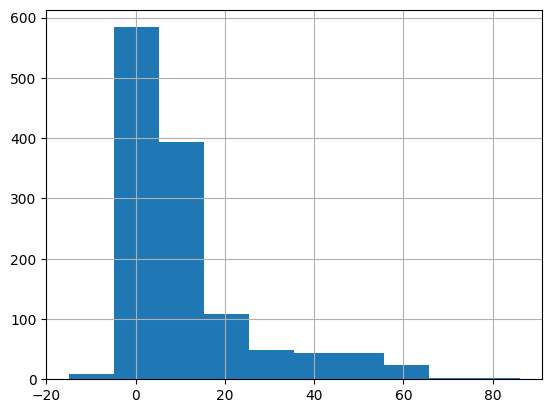

In [31]:
alldata.m3f2c2.hist()

Test Brier: 0.0479
Test F1: 0.1250
Leaderboard Brier: 0.0547
Leaderboard F1: 0.0645
Holdout Brier: 0.0589
